In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.models.vae import VAE, VAELoss
from torchlake.common.controller.trainer import SingleInputMultiOutputRegressionTrainer
from torchlake.common.controller.weight_manager import WeightManager
from torchvision.transforms import v2

# Setting

In [2]:
IMAGE_SIZE = 28
BATCH_SIZE = 2048

In [3]:
DEVICE = torch.device("cuda:0")

In [4]:
artifact_path = Path("../../artifacts/vae")
data_path = Path("../../data/mnist")

# Data

In [5]:
preprocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

In [6]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

# model

In [8]:
LATENT_DIM = 64

In [9]:
model = VAE(
    input_channel=1,
    image_size=28 * 28,
    hidden_dim=256,
    latent_dim=LATENT_DIM,
).to(DEVICE)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
VAE                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       200,960
│    └─ReLU: 2-2                         --
├─ModuleDict: 1-2                        --
│    └─Linear: 2-3                       16,448
│    └─Linear: 2-4                       16,448
├─Sequential: 1-3                        --
│    └─Linear: 2-5                       16,640
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       201,488
Total params: 451,984
Trainable params: 451,984
Non-trainable params: 0

# train

In [135]:
EPOCHS = 15

In [136]:
trainer = SingleInputMultiOutputRegressionTrainer(EPOCHS, DEVICE)

In [137]:
criterion = VAELoss(kld_weight=1, loss_type="mse")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [138]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [ ]:
scaler = torch.amp.GradScaler()

In [140]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler=scheduler, scaler=scaler)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Enable AMP: True
Calculating dataset size...


100%|██████████| 29/29 [00:13<00:00,  2.10it/s]


Training...


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


Epoch 1 : 105.50547053896149 (0%)


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


Epoch 2 : 60.483253479003906 (-43%)


100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


Epoch 3 : 52.83138788157494 (-13%)


100%|██████████| 29/29 [00:13<00:00,  2.14it/s]


Epoch 4 : 47.95234706484039 (-9%)


100%|██████████| 29/29 [00:13<00:00,  2.15it/s]


Epoch 5 : 45.178790783060016 (-6%)


100%|██████████| 29/29 [00:13<00:00,  2.14it/s]


Epoch 6 : 43.5304840350973 (-4%)


100%|██████████| 29/29 [00:13<00:00,  2.12it/s]


Epoch 7 : 42.32613925276132 (-3%)


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Epoch 8 : 41.23978595075936 (-3%)


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


Epoch 9 : 40.0218761049468 (-3%)


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Epoch 10 : 38.936743506069845 (-3%)


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Epoch 11 : 37.980844826533875 (-2%)


100%|██████████| 29/29 [00:15<00:00,  1.85it/s]


Epoch 12 : 37.260702067408076 (-2%)


100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


Epoch 13 : 36.70538619468952 (-1%)


100%|██████████| 29/29 [00:13<00:00,  2.16it/s]


Epoch 14 : 36.25803072699185 (-1%)


100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

Epoch 15 : 36.00101576180295 (-1%)


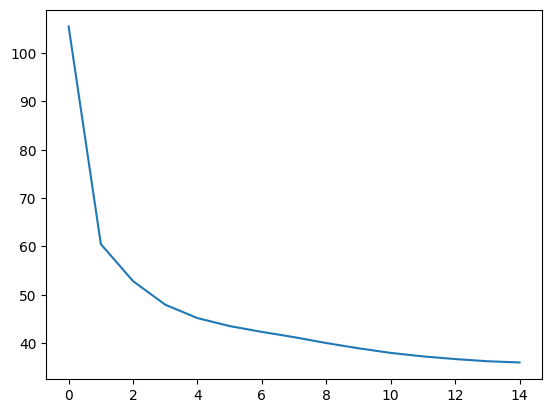

In [141]:
plt.plot(training_loss)

In [11]:
manager = WeightManager(artifact_path.joinpath("vae.pth").as_posix())

In [12]:
model_path = manager.get_filename()
model_path

WindowsPath('../../artifacts/vae/vae.pth')

In [144]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\vae\vae.pth, model size is 1.73MiB


In [13]:
manager.load_weight(model_path, model)

# Eval

In [146]:
# import numpy as np
# import cv2

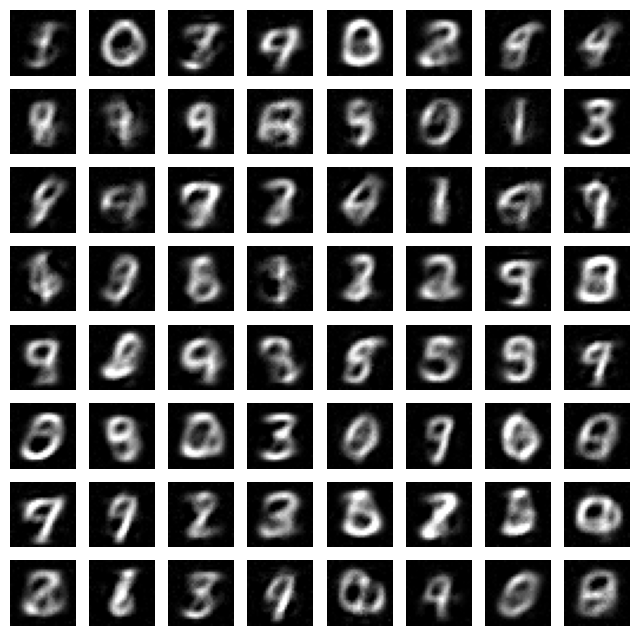

In [ ]:
# 合成圖片

model.eval()
with torch.no_grad():
    noise = generate_normal(64, LATENT_DIM).to(DEVICE)
    gen_img = model.decode(noise, (-1, 1, IMAGE_SIZE, IMAGE_SIZE))
    # gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())
    gen_img.clip_(0, 1)
    # gen_img = img_tensor_to_np(gen_img, scale=255, output_type=np.uint8)
    gen_img = img_tensor_to_np(gen_img)
    # for i, img in enumerate(gen_img):
    #     img = cv2.GaussianBlur(img, (5, 5), 0)
    #     # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    #     # img = clahe.apply(img)
    #     img = cv2.adaptiveThreshold(
    #         img,
    #         255,
    #         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #         cv2.THRESH_BINARY_INV,
    #         11,
    #         2,
    #     )

        # gen_img[i] = img[:, :, None]

    plot_grids(
        gen_img,
        num_row=8,
        num_col=8,
        is_gray_scale=True,
    )